In [37]:
#%pip install --upgrade pymc pymc-bart pytensor

In [38]:
import os
os.environ['PATH'] = 'C:\\mingw64\\bin;' + os.environ['PATH']
os.environ['PYTENSOR_FLAGS'] = 'mode=FAST_COMPILE'

In [39]:
import pymc as pm
import pymc_bart as pmb
from pymc_bart import BART
import numpy as np
import xarray as xr
import pandas as pd

In [40]:
import os
print(os.getcwd())

c:\Users\mrlem\cursor_ws\FSAN830_horse\fsan830spring2025\students\Buskin_Evgeny\Horse_bets


In [41]:
from pathlib import Path
import xml.etree.ElementTree as ET

def parse_horse_positions(xml_relative_path):
    xml_path = Path("..") / ".." / ".." / xml_relative_path  
    tree = ET.parse(xml_path)
    root = tree.getroot()

    all_entries = []

    for race in root.findall("RACE"):
        race_number = race.get("NUMBER")

        for entry in race.findall("ENTRY"):
            horse_name = entry.findtext("NAME")
            official_finish = entry.findtext("OFFICIAL_FIN")
            program_num = entry.findtext("PROGRAM_NUM")
            dollar_odds = entry.findtext("DOLLAR_ODDS")

            entry_data = {
                "race_number": int(race_number),
                "horse_name": horse_name.strip() if horse_name else None,
                "official_finish": int(official_finish) if official_finish else None,
                "program_number": program_num.strip() if program_num else None,
                "dollar_odds": float(dollar_odds) if dollar_odds else None
            }

            all_entries.append(entry_data)

    return all_entries


In [42]:
data = parse_horse_positions("data/rawDataForTraining/resultsData/cd20230502tch.xml")


In [43]:
results_df = pd.DataFrame(data)
results_df.head(10)

,race_number,horse_name,official_finish,program_number,dollar_odds
0,1,Gormleyesque,2,1,2.73
1,1,Kentucky Reign,3,2,2.26
2,1,Dogwoodsmilliejane,1,4,12.80
3,1,Girls House,4,5,1.11
4,1,Recite,5,6,15.07
5,1,Start Class,6,7,31.16
6,2,Golden View,7,1,2.89
7,2,dh-Party At Grants,2,2,4.03
8,2,Luna Moth,1,3,3.74
9,2,Rudimentary Drink,4,4,8.55


In [44]:
workspace_root = Path("c:/Users/mrlem/cursor_ws/FSAN830_horse/fsan830spring2025")

In [45]:
# multiple case (for all files resultsData folder)
def parse_horse_positions(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    all_entries = []

    for race in root.findall("RACE"):
        race_number = race.get("NUMBER")

        for entry in race.findall("ENTRY"):
            horse_name = entry.findtext("NAME")
            official_finish = entry.findtext("OFFICIAL_FIN")
            program_num = entry.findtext("PROGRAM_NUM")
            dollar_odds = entry.findtext("DOLLAR_ODDS")

            entry_data = {
                "race_number": int(race_number),
                "horse_name": horse_name.strip() if horse_name else None,
                "official_finish": int(official_finish) if official_finish else None,
                "program_number": program_num.strip() if program_num else None,
                "dollar_odds": float(dollar_odds) if dollar_odds else None
            }

            all_entries.append(entry_data)

    return all_entries

# Path to resultsData folder
results_folder = workspace_root / "data" / "rawDataForTraining" / "resultsData"
#print(f"Looking for XML files in: {results_folder.absolute()}")  # Debug print

all_results = []

# Step 3: Loop through all XML files and parse
for xml_file in results_folder.glob("*.xml"):
    try:
        parsed = parse_horse_positions(xml_file)
        all_results.extend(parsed)
    except Exception as e:
        print(f"Error parsing {xml_file.name}: {e}")

# Step 4: Convert to DataFrame
results_df = pd.DataFrame(all_results)
results_df['horse_name'] = results_df['horse_name'].str.strip().str.lower()
print("Combined DataFrame shape:", results_df.shape)

Combined DataFrame shape: (1482, 5)


In [46]:
results_df.head(10)

,race_number,horse_name,official_finish,program_number,dollar_odds
0,1,gormleyesque,2,1,2.73
1,1,kentucky reign,3,2,2.26
2,1,dogwoodsmilliejane,1,4,12.80
3,1,girls house,4,5,1.11
4,1,recite,5,6,15.07
5,1,start class,6,7,31.16
6,2,golden view,7,1,2.89
7,2,dh-party at grants,2,2,4.03
8,2,luna moth,1,3,3.74
9,2,rudimentary drink,4,4,8.55


In [47]:
import xml.etree.ElementTree as ET
from pathlib import Path
import pandas as pd
from datetime import datetime

def parse_fractional_odds(odds_str):
    if not odds_str:
        return None
    try:
        if "/" in odds_str:
            num, denom = odds_str.split("/")
            return round(float(num) / float(denom), 2)
        return float(odds_str)
    except:
        return None

def safe_findtext(node, path):
    try:
        found = node.find(path)
        return found.text.strip() if found is not None and found.text else None
    except:
        return None

def parse_date(date_str):
    try:
        if not date_str:
            return None
        # Remove timezone part if present
        date_str = date_str.split('+')[0]
        return datetime.strptime(date_str, "%Y-%m-%d").strftime('%Y-%m-%d')
    except:
        return None
    
def parse_distance(dist_str):
    try:
        if not dist_str:
            return np.nan
        dist_str = dist_str.lower()
        if 'm' in dist_str:
            parts = dist_str.split('m')[0].strip().split()
            if len(parts) == 1:
                distance = float(parts[0])
            else:
                whole = float(parts[0])
                num, denom = map(float, parts[1].split('/'))
                distance = whole + (num / denom)
            return distance * 8
        elif 'f' in dist_str:
            parts = dist_str.split('f')[0].strip().split()
            if len(parts) == 1:
                return float(parts[0])
            else:
                whole = float(parts[0])
                num, denom = map(float, parts[1].split('/'))
                return whole + (num / denom)
        else:
            return float(dist_str)
    except:
        return np.nan

In [48]:
pastPerf_path = workspace_root / "data" / "rawDataForTraining" / "pastPerformanceData"

def parse_past_performance_xml(xml_file, filename="sample.xml"):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        all_rows = []

        for race in root.findall("Race"):
            race_number = race.findtext("RaceNumber")
            post_time = race.findtext("PostTime")
            distance = race.find("Distance/PublishedValue")
            surface = race.find("Course/CourseType/Description")
            race_type = race.find("RaceType/Description")
            purse = race.findtext("PurseUSA")

            distance_val = parse_distance(distance.text) if distance is not None else np.nan
            surface_val = surface.text if surface is not None else None
            race_type_val = race_type.text if race_type is not None else None
            purse_val = float(purse) if purse else np.nan

            for starter in race.findall("Starters"):
                horse_elem = starter.find("Horse")
                if horse_elem is None:
                    continue

                horse_name = horse_elem.findtext("HorseName")
                jockey = starter.find("Jockey/LastName")
                trainer = starter.find("Trainer/LastName")
                program_number = starter.findtext("ProgramNumber")

                current_row = {
                    "RaceID": f"{filename.replace('.xml', '')}_R{race_number}",
                    "RaceNumber": race_number,
                    "PostTime": post_time,
                    "Distance": distance_val,
                    "Surface": surface_val,
                    "RaceType": race_type_val,
                    "Purse": purse_val,
                    "HorseName": horse_name,
                    "Jockey": jockey.text if jockey is not None else '',
                    "Trainer": trainer.text if trainer is not None else '',
                    "ProgramNumber": program_number
                }

                past_perf_elements = starter.findall('PastPerformance')[:5]
                for i, perf in enumerate(past_perf_elements):
                    start_elem = perf.find('Start')
                    if start_elem is None:
                        continue

                    try:
                        race_date = parse_date(perf.findtext("RaceDate"))
                        surface = perf.find("Course/Surface/Value")
                        distance = perf.find("Distance/PublishedValue")
                        purse = perf.findtext("PurseUSA")
                        num_starters = perf.findtext("NumberOfStarters")
                        track = perf.find("Track/TrackID")
                        race_num = perf.find("RaceNumber")

                        lengths_last_call = np.nan
                        lengths_finish = np.nan
                        start_pos = np.nan
                        finish_pos = np.nan
                        last_call_pos = np.nan

                        for call in start_elem.findall("PointOfCall"):
                            poc = call.findtext("PointOfCall")
                            if poc == 'S':
                                pos = call.findtext("Position")
                                if pos: start_pos = int(pos)
                            elif poc == 'F':
                                pos = call.findtext("Position")
                                if pos: finish_pos = int(pos)
                                if finish_pos != 1:
                                    lb = call.findtext("LengthsBehind")
                                    if lb: lengths_finish = float(lb)
                            if call.findtext("PointOfCallPrint") == 'Y':
                                pos = call.findtext("Position")
                                if pos: last_call_pos = int(pos)
                                lb = call.findtext("LengthsBehind")
                                if lb: lengths_last_call = float(lb)

                        past_prefix = f"PP{i+1}_"
                        current_row.update({
                            past_prefix + "RaceID": f"{track.text}-{race_date}-R{race_num.text}" if track is not None and race_num is not None else None,
                            past_prefix + "RaceDate": race_date,
                            past_prefix + "Surface": surface.text if surface is not None else None,
                            past_prefix + "Distance": parse_distance(distance.text) if distance is not None else np.nan,
                            past_prefix + "Purse": float(purse) if purse else np.nan,
                            past_prefix + "NumStarters": int(num_starters) if num_starters else np.nan,
                            past_prefix + "FinishPosition": finish_pos,
                            past_prefix + "LengthsBackFinish": lengths_finish,
                            past_prefix + "LengthsBackLastCall": lengths_last_call,
                            past_prefix + "StartPosition": start_pos,
                            past_prefix + "LastCallPosition": last_call_pos,
                            past_prefix + "Jockey": start_elem.findtext("Jockey/LastName") or '',
                            past_prefix + "Trainer": start_elem.findtext("Trainer/LastName") or '',
                        })
                    except Exception:
                        continue

                all_rows.append(current_row)

        return pd.DataFrame(all_rows)

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return pd.DataFrame()
    
# Parse all uploaded files
all_dfs = []
print(f"Parsing files in {pastPerf_path}")
for fname in pastPerf_path.glob("*.xml"):  
    df = parse_past_performance_xml(fname, filename=fname.name)
    all_dfs.append(df)

pp_df = pd.concat(all_dfs, ignore_index=True)
pp_df["DistanceYards"] = pp_df["Distance"] * 220
pp_df.to_csv("training_data_pp.csv", index=False)


Parsing files in c:\Users\mrlem\cursor_ws\FSAN830_horse\fsan830spring2025\data\rawDataForTraining\pastPerformanceData


In [49]:
pp_df.head()

,RaceID,RaceNumber,PostTime,Distance,Surface,RaceType,Purse,HorseName,Jockey,Trainer,ProgramNumber,PP1_RaceID,PP1_RaceDate,PP1_Surface,PP1_Distance,PP1_Purse,PP1_NumStarters,PP1_FinishPosition,PP1_LengthsBackFinish,PP1_LengthsBackLastCall,PP1_StartPosition,PP1_LastCallPosition,PP1_Jockey,PP1_Trainer,PP2_RaceID,PP2_RaceDate,PP2_Surface,PP2_Distance,PP2_Purse,PP2_NumStarters,PP2_FinishPosition,PP2_LengthsBackFinish,PP2_LengthsBackLastCall,PP2_StartPosition,PP2_LastCallPosition,PP2_Jockey,PP2_Trainer,PP3_RaceID,PP3_RaceDate,PP3_Surface,PP3_Distance,PP3_Purse,PP3_NumStarters,PP3_FinishPosition,PP3_LengthsBackFinish,PP3_LengthsBackLastCall,PP3_StartPosition,PP3_LastCallPosition,PP3_Jockey,PP3_Trainer,PP4_RaceID,PP4_RaceDate,PP4_Surface,PP4_Distance,PP4_Purse,PP4_NumStarters,PP4_FinishPosition,PP4_LengthsBackFinish,PP4_LengthsBackLastCall,PP4_StartPosition,PP4_LastCallPosition,PP4_Jockey,PP4_Trainer,PP5_RaceID,PP5_RaceDate,PP5_Surface,PP5_Distance,PP5_Purse,PP5_NumStarters,PP5_FinishPosition,PP5_LengthsBackFinish,PP5_LengthsBackLastCall,PP5_StartPosition,PP5_LastCallPosition,PP5_Jockey,PP5_Trainer,DistanceYards
0,SIMD20230502CD_USA_R1,1,12:45PM,7.0,Dirt,MAIDEN CLAIMING,30000.0,Gormleyesque,Rodriguez,Catalano,1,KEE-2023-04-19-R3,2023-04-19,D,6.0,43000.0,11.0,4.0,550.0,550.0,1.0,4.0,Peterson,Catalano,TP-2023-03-25-R6,2023-03-25,D,6.0,70000.0,11.0,7.0,1550.0,1550.0,1.0,7.0,Loveberry,Catalano,TP-2023-02-15-R5,2023-02-15,D,6.5,70000.0,12.0,9.0,1750.0,1750.0,7.0,9.0,Mojica,Catalano,SAR-2022-08-04-R2,2022-08-04,T,5.5,105000.0,9.0,7.0,950.0,950.0,4.0,7.0,Saez,Catalano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1540.0
1,SIMD20230502CD_USA_R1,1,12:45PM,7.0,Dirt,MAIDEN CLAIMING,30000.0,Kentucky Reign,Navas,Colebrook,2,KEE-2023-04-19-R4,2023-04-19,T,8.0,100000.0,12.0,11.0,1860.0,1860.0,6.0,11.0,Navas,Colebrook,TP-2023-03-25-R6,2023-03-25,D,6.0,70000.0,11.0,10.0,2225.0,2225.0,7.0,10.0,Machado,Colebrook,CD-2022-08-13-R1,2022-08-13,D,6.0,120000.0,10.0,9.0,9999.0,9999.0,2.0,9.0,Corrales,Colebrook,ELP-2022-07-31-R2,2022-07-31,D,7.0,33000.0,8.0,2.0,175.0,175.0,6.0,2.0,Corrales,Colebrook,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1540.0
2,SIMD20230502CD_USA_R1,1,12:45PM,7.0,Dirt,MAIDEN CLAIMING,30000.0,Toto'srubyslippers,Loveberry,Sims,3,KEE-2022-10-29-R1,2022-10-29,D,6.0,43000.0,7.0,3.0,475.0,475.0,5.0,3.0,Hernandez,Dunn,TP-2022-02-11-R10,2022-02-11,D,8.0,24000.0,11.0,8.0,1275.0,1275.0,11.0,8.0,Lezcano,Dunn,TP-2022-01-08-R8,2022-01-08,D,8.0,29000.0,12.0,8.0,805.0,805.0,11.0,8.0,Achard,Dunn,TP-2021-12-09-R5,2021-12-09,D,6.0,62000.0,12.0,10.0,2325.0,2325.0,11.0,10.0,Achard,Dunn,IND-2021-11-11-R6,2021-11-11,D,5.5,34000.0,7.0,5.0,1250.0,1250.0,7.0,5.0,Pompell,Dunn,1540.0
3,SIMD20230502CD_USA_R1,1,12:45PM,7.0,Dirt,MAIDEN CLAIMING,30000.0,Dogwoodsmilliejane,Gilligan,Taylor,4,TP-2023-02-15-R3,2023-02-15,D,8.0,25000.0,11.0,6.0,1780.0,1780.0,11.0,6.0,Heard,Taylor,TP-2022-12-02-R1,2022-12-02,D,6.5,25000.0,8.0,7.0,765.0,765.0,7.0,7.0,Gilligan,Taylor,CD-2022-11-20-R4,2022-11-20,D,6.5,37000.0,9.0,5.0,685.0,685.0,9.0,5.0,Court,Taylor,KEE-2022-10-19-R2,2022-10-19,D,7.0,47000.0,9.0,9.0,1725.0,1725.0,6.0,9.0,Miller,Taylor,CD-2022-09-16-R1,2022-09-16,D,6.0,58000.0,8.0,8.0,850.0,850.0,8.0,8.0,Miller,Taylor,1540.0
4,SIMD20230502CD_USA_R1,1,12:45PM,7.0,Dirt,MAIDEN CLAIMING,30000.0,Girls House,Saez,Cano,5,TP-2023-03-18-R7,2023-03-18,D,8.0,25000.0,9.0,6.0,240.0,240.0,4.0,6.0,Esquivel,Cano,TP-2023-02-25-R1,2023-02-25,D,8.0,30000.0,10.0,4.0,285.0,285.0,3.0,4.0,Esquivel,Cano,TP-2023-02-15-R3,2023-02-15,D,8.0,25000.0,11.0,2.0,400.0,400.0,1.0,2.0,Corrales,Cano,TP-2023-01-26-R2,2023-01-26,D,6.5,30000.0,9.0,6.0,1775.0,1775.0,4.0,6.0,Sanjur,Cano,TP-2022-12-28-R10,2022-12-28,D,8.0,30000.0,11.0,4.0,475.0,475.0,8.0,4.0,Sanjur,Cano,1540.0


In [50]:
def parse_horse_features_pp(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    features = []

    for race in root.findall("Race"):
        race_number = safe_findtext(race, "RaceNumber")
        race_date = safe_findtext(root, "RaceCardDate") 
        race_date_parsed = parse_date(race_date)

        for starter in race.findall("Starters"):
            horse = starter.find("Horse")
            sire = horse.find("Sire") if horse is not None else None
            dam = horse.find("Dam") if horse is not None else None

            # Past Performance Aggregates
            avg_finish = None
            avg_speed_fig = None
            avg_days_since = None
            top3_count = 0

            past_perfs = starter.findall("PastPerformance")
            past_perfs = past_perfs[:5] #looking on last 5
            finishes = []
            speed_figs = []
            days_since = []

            for pp in past_perfs:
                finish = safe_findtext(pp, "FinishPosition")
                speed = safe_findtext(pp, "SpeedFigure")
                pp_date = parse_date(safe_findtext(pp, "RaceDate"))

                if finish and finish.isdigit():
                    finish = int(finish)
                    finishes.append(finish)
                    if finish <= 3:
                        top3_count += 1

                if speed and speed.isdigit():
                    speed_figs.append(int(speed))

                if pp_date and race_date_parsed:
                    delta = (race_date_parsed - pp_date).days
                    days_since.append(delta)

            if finishes:
                avg_finish = round(sum(finishes) / len(finishes), 2)
            if speed_figs:
                avg_speed_fig = round(sum(speed_figs) / len(speed_figs), 2)
            if days_since:
                avg_days_since = round(sum(days_since) / len(days_since), 2)

            features.append({
                "race_number": int(race_number) if race_number else None,
                "horse_name": safe_findtext(horse, "HorseName").lower() if horse is not None else None,
                "program_number": safe_findtext(starter, "ProgramNumber"),
                "post_position": int(safe_findtext(starter, "PostPosition") or 0),
                "weight_carried": int(safe_findtext(starter, "WeightCarried") or 0),
                "odds": parse_fractional_odds(safe_findtext(starter, "Odds")),
                "jockey": safe_findtext(starter, "Jockey/LastName"),
                "trainer": safe_findtext(starter, "Trainer/LastName"),
                "owner": safe_findtext(starter, "Owner/LastName"),
                "speed_figure": int(safe_findtext(starter, "Start/SpeedFigure") or 0),
                "class_rating": float(safe_findtext(starter, "Start/ClassRating") or 0),
                "sex": safe_findtext(horse, "Sex/Value") if horse is not None else None,
                "breed_type": safe_findtext(horse, "BreedType/Value") if horse is not None else None,
                "foaling_area": safe_findtext(horse, "FoalingArea") if horse is not None else None,
                "color": safe_findtext(horse, "Color/Value") if horse is not None else None,
                "medication": safe_findtext(starter, "Medication/Value"),
                "equipment": safe_findtext(starter, "Equipment/Value"),
                "sire_name": safe_findtext(sire, "HorseName") if sire is not None else None,
                "dam_name": safe_findtext(dam, "HorseName") if dam is not None else None,
                "avg_finish_last_5": avg_finish,
                "top3_count_last_5": top3_count,
                "avg_days_since_last_5": avg_days_since,
                "avg_speed_fig_last_5": avg_speed_fig
            })

    return features

# Load all horse features
perf_folder = workspace_root / "data" / "rawDataForTraining" / "pastPerformanceData"
all_features = []

for xml_file in perf_folder.glob("*.xml"):
    try:
        all_features.extend(parse_horse_features_pp(xml_file))
    except Exception as e:
        print(f"Error parsing {xml_file.name}: {e}")

features_df = pd.DataFrame(all_features)
features_df['horse_name'] = features_df['horse_name'].str.strip().str.lower()
features_df.shape

(1757, 23)

In [51]:
features_df.tail()

,race_number,horse_name,program_number,post_position,weight_carried,odds,jockey,trainer,owner,speed_figure,class_rating,sex,breed_type,foaling_area,color,medication,equipment,sire_name,dam_name,avg_finish_last_5,top3_count_last_5,avg_days_since_last_5,avg_speed_fig_last_5
1752,9,rosy tomorrows,11,11,118,8.0,Corrales,Maker,Nice Guys Stables,0,0.0,F,TB,KY,B,L,B,Kitten's Joy,Restless Spirit,None,0,None,None
1753,9,holy foley,12,12,118,12.0,Graham,Lynch,Perrine Time Thoroughbreds,0,0.0,F,TB,KY,CH,L,B,Point of Entry,Belissimo,None,0,None,None
1754,9,first hill,13,13,118,15.0,Landeros,Medina,Bozarth,0,0.0,F,TB,KY,Dk B/Br,L,None,West Coast,Singlet,None,0,None,None
1755,9,catherine blaze,14,14,118,20.0,Bejarano,"Leonard, III",Carney,0,0.0,F,TB,KY,GR/RO,L,None,Cross Traffic,Carrie,None,0,None,None
1756,9,my tallulah,15,15,118,15.0,Leparoux,Mott,"Gray, Fletcher and Carolyn",0,0.0,F,TB,KY,B,L,None,Honor Code,Chit Chatter,None,0,None,None


In [52]:
merged_df = pd.merge(
    results_df,
    features_df,
    on=["race_number", "horse_name"],
    how="left"
)

print("Final merged DataFrame shape:", merged_df.shape)
print(merged_df.head())
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Final merged DataFrame shape: (1521, 26)
   race_number          horse_name  official_finish program_number_x  \
0            1        gormleyesque                2                1   
1            1      kentucky reign                3                2   
2            1  dogwoodsmilliejane                1                4   
3            1         girls house                4                5   
4            1              recite                5                6   

   dollar_odds program_number_y  post_position  weight_carried  odds  \
0         2.73                1            1.0           113.0   1.6   
1         2.26                2            2.0           108.0   8.0   
2        12.80                4            4.0           124.0  12.0   
3         1.11                5            5.0           124.0   1.2   
4        15.07                6            6.0           118.0  15.0   

      jockey    trainer                                  owner  speed_figure  \
0  Rodriguez 

In [53]:
from string import ascii_lowercase, digits

raceresult_path = workspace_root / "data" / "rawDataForTraining" / "resultsData"
def create_race_id(track_code, date_str, race_number):
    try:
        # Validate inputs
        if not track_code or not date_str or not race_number:
            return None
        # Split date and validate format
        date_parts = date_str.split("-")
        if len(date_parts) != 3:
            return None  
        month, day, year = date_parts
        # Format the parts
        month = month.zfill(2)  # Ensure 2 digits
        day = day.zfill(2)      # Ensure 2 digits
        year = year[-2:]        # Use last 2 digits
        # Create race ID
        return f"{track_code}-{month}-{day}-{year}-R{int(race_number):02d}"
        
    except (ValueError, AttributeError):
        return None

def standardize_race_id(race_id):
    try:
        # Handle RaceID from features_df 
        if race_id.startswith('SIMD') and '_R' in race_id:
            # Extract date and race number
            date_part = race_id[4:12]  # Gets "20231104"
            race_num = race_id.split('_R')[1]  # Gets "1"
            # Format the date parts
            year = date_part[2:4]  # Last 2 digits of year
            month = date_part[4:6]
            day = date_part[6:8]
            
            return f"CD-{month}-{day}-{year}-R{int(race_num):02d}"
        # If already in CD-MM-DD-YY-RNN format, return as is
        if race_id.startswith('CD-'):
            return race_id
        return race_id
    except:
        return race_id

def normalize_horse_name(name):
    if not name or pd.isna(name):
        return ""
    # Convert to string, lowercase, and strip whitespace
    name = str(name).lower().strip()
    # Handle different apostrophes
    name = name.replace("'", "'").replace("`", "'")
    # Remove punctuation except apostrophes and spaces
    allowed_chars = ascii_lowercase + digits + "' " 
    name = ''.join(char for char in name if char in allowed_chars)
    # Normalize spaces (replace multiple spaces with single space)
    while '  ' in name:
        name = name.replace('  ', ' ')
    return name.strip()

def parse_race_result_xml(xml_file, filename="unknown.xml"):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        results = []

        races = root.findall("RACE") if root.tag != "CHART" else root.findall(".//RACE")

        for idx, race in enumerate(races):
            race_date = race.findtext("RACE_DATE")
            race_number = race.findtext("RACE_NUMBER")
            track_code = "CD"

            # If date/number not found, try to extract from filename
            if not race_date or not race_number:
                if filename.startswith('cd') and filename.endswith('.xml'):
                    # Extract date from filename (format: cd20230502tch.xml)
                    date_str = filename[2:10]  # Get "20230502"
                    month = date_str[4:6]
                    day = date_str[6:8]
                    year = date_str[2:4]
                    race_date = f"{month}-{day}-{year}"
                    race_number = str(idx + 1)
                else:
                    continue

            # Create race ID using our existing method
            race_id = create_race_id(track_code, race_date, race_number)
            if not race_id:
                continue

            # Process entries
            for entry in race.findall("ENTRY"):
                horse_name = entry.findtext("NAME")
                finish = entry.findtext("OFFICIAL_FIN")
                
                if horse_name and finish and finish.isdigit():
                    results.append({
                        "RaceID": race_id,
                        "HorseName": normalize_horse_name(horse_name),
                        "FinishPosition": int(finish)
                    })

        return pd.DataFrame(results)
    except Exception as e:
        print(f"Error parsing {filename}: {e}")
        return pd.DataFrame()

# Parse result files
all_results = []
print(f"Parsing results...")
for fname in raceresult_path.glob("*.xml"):
    df = parse_race_result_xml(fname, filename=fname.name)
    if not df.empty:
        all_results.append(df)
if not all_results:
            raise ValueError("No race results were processed successfully")

results_df = pd.concat(all_results, ignore_index=True)

# Load features
features_df = pd.read_csv("training_data_pp.csv")
features_df["RaceID"] = features_df["RaceID"].apply(standardize_race_id)
features_df["HorseName"] = features_df["HorseName"].apply(normalize_horse_name)
results_df["HorseName"] = results_df["HorseName"].apply(normalize_horse_name)

# Log unique RaceIDs for debugging
print("Unique RaceIDs in features_df:", len(features_df["RaceID"].unique()))
print("Unique RaceIDs in results_df:", len(results_df["RaceID"].unique()))

# Merge with diagnostics
merged_df = pd.merge(
    features_df,
    results_df,
    on=["RaceID", "HorseName"],
    how="left",
    indicator=True
)

# Analyze unmatched rows
unmatched = merged_df[merged_df["_merge"] == "left_only"]
print(f"\n Merge Analysis:")
print(f"Total rows: {len(merged_df)}")
print(f"Matched rows: {len(merged_df[merged_df['_merge'] == 'both'])}")
print(f"Unmatched rows: {len(unmatched)}")

if len(unmatched) > 0:
    print("\nSample of unmatched entries:")
    print(unmatched[["RaceID", "HorseName"]].head())

# Keep only matched rows
merged_df = merged_df[merged_df["_merge"] == "both"].copy()
merged_df.drop(columns=["_merge"], inplace=True)

# Ensure FinishPosition is integer
merged_df["FinishPosition"] = merged_df["FinishPosition"].astype(int)
merged_df.shape

Parsing results...
Unique RaceIDs in features_df: 179
Unique RaceIDs in results_df: 179

 Merge Analysis:
Total rows: 1757
Matched rows: 1470
Unmatched rows: 287

Sample of unmatched entries:
             RaceID           HorseName
2   CD-05-02-23-R01  toto'srubyslippers
8   CD-05-02-23-R02     party at grants
11  CD-05-02-23-R02   lotsandlotsofgold
30  CD-05-02-23-R04  a little bit crazy
38  CD-05-02-23-R05             sake fr


(1470, 78)

In [54]:
merged_df.head()

,RaceID,RaceNumber,PostTime,Distance,Surface,RaceType,Purse,HorseName,Jockey,Trainer,ProgramNumber,PP1_RaceID,PP1_RaceDate,PP1_Surface,PP1_Distance,PP1_Purse,PP1_NumStarters,PP1_FinishPosition,PP1_LengthsBackFinish,PP1_LengthsBackLastCall,PP1_StartPosition,PP1_LastCallPosition,PP1_Jockey,PP1_Trainer,PP2_RaceID,PP2_RaceDate,PP2_Surface,PP2_Distance,PP2_Purse,PP2_NumStarters,PP2_FinishPosition,PP2_LengthsBackFinish,PP2_LengthsBackLastCall,PP2_StartPosition,PP2_LastCallPosition,PP2_Jockey,PP2_Trainer,PP3_RaceID,PP3_RaceDate,PP3_Surface,PP3_Distance,PP3_Purse,PP3_NumStarters,PP3_FinishPosition,PP3_LengthsBackFinish,PP3_LengthsBackLastCall,PP3_StartPosition,PP3_LastCallPosition,PP3_Jockey,PP3_Trainer,PP4_RaceID,PP4_RaceDate,PP4_Surface,PP4_Distance,PP4_Purse,PP4_NumStarters,PP4_FinishPosition,PP4_LengthsBackFinish,PP4_LengthsBackLastCall,PP4_StartPosition,PP4_LastCallPosition,PP4_Jockey,PP4_Trainer,PP5_RaceID,PP5_RaceDate,PP5_Surface,PP5_Distance,PP5_Purse,PP5_NumStarters,PP5_FinishPosition,PP5_LengthsBackFinish,PP5_LengthsBackLastCall,PP5_StartPosition,PP5_LastCallPosition,PP5_Jockey,PP5_Trainer,DistanceYards,FinishPosition
0,CD-05-02-23-R01,1,12:45PM,7.0,Dirt,MAIDEN CLAIMING,30000.0,gormleyesque,Rodriguez,Catalano,1,KEE-2023-04-19-R3,2023-04-19,D,6.0,43000.0,11.0,4.0,550.0,550.0,1.0,4.0,Peterson,Catalano,TP-2023-03-25-R6,2023-03-25,D,6.0,70000.0,11.0,7.0,1550.0,1550.0,1.0,7.0,Loveberry,Catalano,TP-2023-02-15-R5,2023-02-15,D,6.5,70000.0,12.0,9.0,1750.0,1750.0,7.0,9.0,Mojica,Catalano,SAR-2022-08-04-R2,2022-08-04,T,5.5,105000.0,9.0,7.0,950.0,950.0,4.0,7.0,Saez,Catalano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1540.0,2
1,CD-05-02-23-R01,1,12:45PM,7.0,Dirt,MAIDEN CLAIMING,30000.0,kentucky reign,Navas,Colebrook,2,KEE-2023-04-19-R4,2023-04-19,T,8.0,100000.0,12.0,11.0,1860.0,1860.0,6.0,11.0,Navas,Colebrook,TP-2023-03-25-R6,2023-03-25,D,6.0,70000.0,11.0,10.0,2225.0,2225.0,7.0,10.0,Machado,Colebrook,CD-2022-08-13-R1,2022-08-13,D,6.0,120000.0,10.0,9.0,9999.0,9999.0,2.0,9.0,Corrales,Colebrook,ELP-2022-07-31-R2,2022-07-31,D,7.0,33000.0,8.0,2.0,175.0,175.0,6.0,2.0,Corrales,Colebrook,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1540.0,3
3,CD-05-02-23-R01,1,12:45PM,7.0,Dirt,MAIDEN CLAIMING,30000.0,dogwoodsmilliejane,Gilligan,Taylor,4,TP-2023-02-15-R3,2023-02-15,D,8.0,25000.0,11.0,6.0,1780.0,1780.0,11.0,6.0,Heard,Taylor,TP-2022-12-02-R1,2022-12-02,D,6.5,25000.0,8.0,7.0,765.0,765.0,7.0,7.0,Gilligan,Taylor,CD-2022-11-20-R4,2022-11-20,D,6.5,37000.0,9.0,5.0,685.0,685.0,9.0,5.0,Court,Taylor,KEE-2022-10-19-R2,2022-10-19,D,7.0,47000.0,9.0,9.0,1725.0,1725.0,6.0,9.0,Miller,Taylor,CD-2022-09-16-R1,2022-09-16,D,6.0,58000.0,8.0,8.0,850.0,850.0,8.0,8.0,Miller,Taylor,1540.0,1
4,CD-05-02-23-R01,1,12:45PM,7.0,Dirt,MAIDEN CLAIMING,30000.0,girls house,Saez,Cano,5,TP-2023-03-18-R7,2023-03-18,D,8.0,25000.0,9.0,6.0,240.0,240.0,4.0,6.0,Esquivel,Cano,TP-2023-02-25-R1,2023-02-25,D,8.0,30000.0,10.0,4.0,285.0,285.0,3.0,4.0,Esquivel,Cano,TP-2023-02-15-R3,2023-02-15,D,8.0,25000.0,11.0,2.0,400.0,400.0,1.0,2.0,Corrales,Cano,TP-2023-01-26-R2,2023-01-26,D,6.5,30000.0,9.0,6.0,1775.0,1775.0,4.0,6.0,Sanjur,Cano,TP-2022-12-28-R10,2022-12-28,D,8.0,30000.0,11.0,4.0,475.0,475.0,8.0,4.0,Sanjur,Cano,1540.0,4
5,CD-05-02-23-R01,1,12:45PM,7.0,Dirt,MAIDEN CLAIMING,30000.0,recite,Morales,Pitts,6,TP-2023-03-30-R4,2023-03-30,D,6.5,30000.0,12.0,11.0,1355.0,1355.0,8.0,11.0,Morales,Pitts,TP-2023-02-09-R8,2023-02-09,D,6.0,30000.0,11.0,8.0,2225.0,2225.0,8.0,8.0,Talamo,Pitts,TP-2023-01-18-R8,2023-01-18,D,6.5,30000.0,12.0,3.0,575.0,575.0,9.0,3.0,Cannon,Pitts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1540.0,5


In [55]:
df = merged_df.copy()
print("Available columns:", df.columns.tolist())
# Transform surface and lengths data
for col in [col for col in df.columns if "Surface" in col]:
    df[col] = df[col].replace({"D": "Dirt", "T": "Turf"})

for col in [col for col in df.columns if "LengthsBack" in col]:
    df[col] = df[col].apply(lambda x: min(x, 100.0) if pd.notna(x) else x)

# Handle missing data
pp_cols = {
    'numerical': [col for col in df.columns if col.startswith("PP") and 
                 ("Distance" in col or "Purse" in col or "Lengths" in col or 
                  "NumStarters" in col or "Position" in col)],
    'categorical': [col for col in df.columns if col.startswith("PP") and 
                   ("Surface" in col or "Jockey" in col or "Trainer" in col)]
}

df[pp_cols['numerical']] = df[pp_cols['numerical']].fillna(0)
df[pp_cols['categorical']] = df[pp_cols['categorical']].fillna("Unknown")

# Calculate features
pp_finish_cols = [f"PP{i}_FinishPosition" for i in range(1, 6)]
pp_distance_cols = [f"PP{i}_Distance" for i in range(1, 6)]
pp_surface_cols = [f"PP{i}_Surface" for i in range(1, 6)]

# Past performance metrics
def replace_zero_with_nan(x):
    return np.nan if x == 0 else x

df["AvgPastFinishPosition"] = df[pp_finish_cols].apply(lambda x: x.map(replace_zero_with_nan)).mean(axis=1).fillna(0)
df["WinRate"] = df[pp_finish_cols].apply(lambda x: x.map(replace_zero_with_nan)).eq(1).sum(axis=1) / \
                       df[pp_finish_cols].apply(lambda x: x.map(replace_zero_with_nan)).notna().sum(axis=1)
df["WinRate"] = df["WinRate"].fillna(0)

# Distance and surface analysis
df["DistanceSuitability"] = df[pp_distance_cols].sub(df["Distance"], axis=0).abs().mean(axis=1).fillna(0)
df["JockeyWinRate"] = df.groupby("Jockey")["FinishPosition"].transform(lambda x: (x == 1).mean())
df["FieldStrength"] = df.groupby("RaceID")["AvgPastFinishPosition"].transform("mean")

# Surface win rate calculation
def surface_win_rate(row):
    current_surface = row.get("Surface", "Unknown")  # Get current surface with default
    matches = sum(1 for i in range(1, 6) 
                 if pd.notna(row.get(f"PP{i}_Surface")) 
                 and row.get(f"PP{i}_Surface") != "Unknown"
                 and row.get(f"PP{i}_FinishPosition") == 1 
                 and row.get(f"PP{i}_Surface") == current_surface)
    total = sum(1 for i in range(1, 6) 
               if pd.notna(row.get(f"PP{i}_Surface")) 
               and row.get(f"PP{i}_Surface") != "Unknown")
    return matches / total if total > 0 else 0

df["SurfaceWinRate"] = df.apply(surface_win_rate, axis=1)

# Normalize distance
df["Distance"] = (df["Distance"] - df["Distance"].min()) / (df["Distance"].max() - df["Distance"].min())

# Create dummy variables for Surface
df = pd.get_dummies(df, columns=["Surface"], prefix="Surface")

# Select and save final features
features = [
    "HorseName", "RaceID", "FinishPosition",
    "Distance", "Surface_Dirt", "Surface_Turf",
    "AvgPastFinishPosition", "WinRate", "DistanceSuitability",
    "JockeyWinRate", "FieldStrength", "SurfaceWinRate"
]

final_df = df[features]

print(f"Dataset shape: {final_df.shape}")
print("Features:", final_df.columns.tolist())
output_path = workspace_root / "students" / "Buskin_Evgeny" / "Horse_bets" / "final_train_ds.csv"
final_df.to_csv(output_path, index=False)

Available columns: ['RaceID', 'RaceNumber', 'PostTime', 'Distance', 'Surface', 'RaceType', 'Purse', 'HorseName', 'Jockey', 'Trainer', 'ProgramNumber', 'PP1_RaceID', 'PP1_RaceDate', 'PP1_Surface', 'PP1_Distance', 'PP1_Purse', 'PP1_NumStarters', 'PP1_FinishPosition', 'PP1_LengthsBackFinish', 'PP1_LengthsBackLastCall', 'PP1_StartPosition', 'PP1_LastCallPosition', 'PP1_Jockey', 'PP1_Trainer', 'PP2_RaceID', 'PP2_RaceDate', 'PP2_Surface', 'PP2_Distance', 'PP2_Purse', 'PP2_NumStarters', 'PP2_FinishPosition', 'PP2_LengthsBackFinish', 'PP2_LengthsBackLastCall', 'PP2_StartPosition', 'PP2_LastCallPosition', 'PP2_Jockey', 'PP2_Trainer', 'PP3_RaceID', 'PP3_RaceDate', 'PP3_Surface', 'PP3_Distance', 'PP3_Purse', 'PP3_NumStarters', 'PP3_FinishPosition', 'PP3_LengthsBackFinish', 'PP3_LengthsBackLastCall', 'PP3_StartPosition', 'PP3_LastCallPosition', 'PP3_Jockey', 'PP3_Trainer', 'PP4_RaceID', 'PP4_RaceDate', 'PP4_Surface', 'PP4_Distance', 'PP4_Purse', 'PP4_NumStarters', 'PP4_FinishPosition', 'PP4_Length

In [56]:
final_df.head()

,HorseName,RaceID,FinishPosition,Distance,Surface_Dirt,Surface_Turf,AvgPastFinishPosition,WinRate,DistanceSuitability,JockeyWinRate,FieldStrength,SurfaceWinRate
0,gormleyesque,CD-05-02-23-R01,2,0.333333,True,False,6.750000,0.0,2.2,0.033333,7.013889,0.0
1,kentucky reign,CD-05-02-23-R01,3,0.333333,True,False,8.000000,0.0,2.0,0.100000,7.013889,0.0
3,dogwoodsmilliejane,CD-05-02-23-R01,1,0.333333,True,False,7.000000,0.0,0.6,0.200000,7.013889,0.0
4,girls house,CD-05-02-23-R01,4,0.333333,True,False,4.400000,0.0,0.9,0.180451,7.013889,0.0
5,recite,CD-05-02-23-R01,5,0.333333,True,False,7.333333,0.0,3.2,0.120000,7.013889,0.0


In [57]:
prediction_data_file_name = "CDX0515.csv"
raw_data_path = workspace_root / "data" / "rawDataForPrediction" / "CDX0515.csv"
column_mapping_path = workspace_root / "students" / "Buskin_Evgeny" / "Horse_bets" / "data" / "column_mapping.csv"
output_path = workspace_root / "students" / "Buskin_Evgeny" / "Horse_bets" / "CDX0515_processed.csv"

# Read the data and mapping files
df = pd.read_csv(raw_data_path, header=None)
mapping_df = pd.read_csv(column_mapping_path)

# Create default column names (col_1, col_2, etc.)
default_columns = [f'col_{i+1}' for i in range(len(df.columns))]
df.columns = default_columns

# Create mapping dictionary
column_mapping = dict(zip(mapping_df['column_number'].astype(int), mapping_df['header_name']))

# Apply headers from mapping where available
for col_num, header_name in column_mapping.items():
    if col_num <= len(df.columns):
        df.rename(columns={f'col_{col_num}': header_name}, inplace=True)

print("Available columns after mapping:", df.columns.tolist())

# Now we can use the column names directly
selected_columns = {
    "Track": "track_code",
    "Date": "race_date",
    "RaceNumber": "race_number",
    "Distance": "distance",
    "Surface": "surface_code",
    "RaceType": "race_type",
    "Jockey": "jockey_name",
    "Odds": "odds",
    "HorseName": "horse_name",
    "Sex": "sex",
    "Color": "color",
    "WeightCarried": "weight",
    "FinishPosition": "recentFinishPosition1"
}

for i in range(1, 6):
    selected_columns.update({
        f"PP{i}_FinishPosition": f"recentFinishPosition{i}",
        f"PP{i}_Distance": f"recentRaceTrackCondition{i}",
        f"PP{i}_Surface": f"recentSurfaceCode{i}",
        f"PP{i}_LengthsBack": f"recentStretchPosition{i}",
        f"PP{i}_NumStarters": f"recentNumEntrants{i}",
        f"PP{i}_Purse": f"recentRaceType{i}",
        f"PP{i}_Jockey": f"recentRaceTrackCode{i}",
        f"PP{i}_Trainer": f"recentRaceNumber{i}"
    })

# Select only the columns we need
df = df[list(selected_columns.values())].copy()
df.columns = list(selected_columns.keys())

Available columns after mapping: ['track_code', 'race_date', 'race_number', 'post_position', 'entry', 'distance', 'surface_code', 'col_8', 'race_type', 'claiming_price_category', 'race_class', 'purse', 'claiming_price', 'claiming_price2', 'speed_rating', 'race_conditions', 'horses_list', 'col_18', 'col_19', 'col_20', 'track_code2', 'race_number2', 'breed_type', 'field_size', 'col_25', 'col_26', 'col_27', 'trainer_name', 'trainer_starts', 'trainer_wins', 'trainer_places', 'trainer_shows', 'trainer_roi', 'jockey_name', 'col_35', 'jockey_starts', 'jockey_wins', 'jockey_places', 'jockey_shows', 'owner_name', 'owner_silks', 'col_42', 'col_43', 'program_number', 'odds', 'horse_name', 'age', 'sex', 'col_49', 'color', 'sire_color', 'weight', 'sire', 'sire_sire', 'dam', 'dam_sire', 'breeder', 'state_bred', 'col_59', 'col_60', 'col_61', 'col_62', 'col_63', 'col_64', 'col_65', 'col_66', 'col_67', 'col_68', 'col_69', 'col_70', 'col_71', 'col_72', 'col_73', 'col_74', 'col_75', 'col_76', 'col_77', '

In [58]:
# Define file paths
prediction_data_file_name = "CDX0515.csv"
raw_data_path = workspace_root / "data" / "rawDataForPrediction" / prediction_data_file_name
column_mapping_path = workspace_root / "students" / "Buskin_Evgeny" / "Horse_bets" / "data" / "column_mapping.csv"

def load_and_prepare_data():
    """
    Load the raw BRISNET CSV file and prepare it for processing.
    Returns the raw DataFrame.
    """
    return pd.read_csv(raw_data_path, header=None)

def calculate_jockey_statistics(df):
    """
    Calculate jockey-level statistics from past performance data.
    Returns dictionaries of jockey average finishes and win rates.
    """
    # Define column indices
    jockey_col = 32
    finish_cols = list(range(616, 626))  # 10 past finish positions

    # Extract jockey and finish position data
    jockey_finish_df = df[[jockey_col] + finish_cols].copy()
    jockey_finish_df.columns = ["Jockey"] + [f"PP{i}_FinishPosition" for i in range(1, 11)]

    # Transform data into long format
    jockey_perf = (
        jockey_finish_df
        .melt(id_vars="Jockey", 
              value_vars=[f"PP{i}_FinishPosition" for i in range(1, 11)],
              value_name="FinishPosition")
        .dropna()
    )
    
    # Convert finish positions to numeric
    jockey_perf["FinishPosition"] = pd.to_numeric(jockey_perf["FinishPosition"], errors="coerce")

    # Calculate statistics
    jockey_avg_finish = jockey_perf.groupby("Jockey")["FinishPosition"].mean().to_dict()
    jockey_winrate = (
        jockey_perf.assign(Won=jockey_perf["FinishPosition"] == 1)
        .groupby("Jockey")["Won"]
        .mean()
        .to_dict()
    )

    return jockey_avg_finish, jockey_winrate

# Select columns (-1 since we start from 0 of 
# https://support.brisnet.com/hc/en-us/articles/360056092092-Data-structure-for-comma-delimited-PP-s-in-the-Single-File-format)
def get_column_mapping():
    """
    Define the mapping between column indices and names.
    Returns a dictionary of column mappings.
    """
    column_map = {
        # Basic race information
        "Track": 0,
        "Date": 1,
        "RaceNumber": 2,
        "Distance": 5,
        "Surface": 6,
        "RaceType": 8,
        
        # Horse and jockey information
        "Jockey": 32,
        "Odds": 43,
        "HorseName": 44,
        "Sex": 48,
        "Color": 49,
        "WeightCarried": 50,
        "FinishPosition": 624,
    }

    # Add past performance columns
    for i in range(5):
        column_map.update({
            f"PP{i+1}_Distance": 315 + i,
            f"PP{i+1}_Surface": 325 + i,
            f"PP{i+1}_NumStarters": 345 + i,
            f"PP{i+1}_Purse": 555 + i,
            f"PP{i+1}_FinishPosition": 615 + i,
            f"PP{i+1}_LengthsBack": 745 + i,
            f"PP{i+1}_Trainer": 1055 + i,
            f"PP{i+1}_Jockey": 1065 + i,
        })

    return column_map

def clean_and_prepare_features(df):
    """
    Clean the data and prepare features for analysis.
    Returns the processed DataFrame.
    """
    # Standardize Surface values
    for col in [c for c in df.columns if "Surface" in c]:
        df[col] = df[col].replace({"D": "Dirt", "T": "Turf"})

    # Cap LengthsBack values
    for col in [c for c in df.columns if "LengthsBack" in c]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df[col] = df[col].apply(lambda x: min(x, 100.0) if pd.notna(x) else x)
    #Adjust horse names to lower case        
    df["HorseName"] = df["HorseName"].str.lower()
    # Handle missing values
    numerical_pp_cols = [c for c in df.columns if c.startswith("PP") and 
                        any(x in c for x in ["Distance", "Purse", "Lengths", "NumStarters", "Position"])]
    categorical_pp_cols = [c for c in df.columns if c.startswith("PP") and 
                          any(x in c for x in ["Surface", "Jockey", "Trainer"])]

    df[numerical_pp_cols] = df[numerical_pp_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    df[categorical_pp_cols] = df[categorical_pp_cols].fillna("Unknown")

    return df

def engineer_features(df, jockey_winrate, jockey_avg_finish):
    """
    Create engineered features for the model.
    Returns the DataFrame with new features.
    """
    # Define column groups
    pp_finish_cols = [f"PP{i}_FinishPosition" for i in range(1, 6)]
    pp_distance_cols = [f"PP{i}_Distance" for i in range(1, 6)]

    # Calculate past performance metrics
    df["AvgPastFinishPosition"] = df[pp_finish_cols].replace(0, np.nan).mean(axis=1).fillna(0)
    df["WinRate"] = df[pp_finish_cols].apply(
        lambda row: (row == 1).sum() / (row != 0).sum() if (row != 0).sum() > 0 else 0, 
        axis=1
    )

    # Calculate distance suitability
    df["Distance"] = pd.to_numeric(df["Distance"], errors="coerce")
    for col in pp_distance_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["DistanceSuitability"] = df[pp_distance_cols].sub(df["Distance"], axis=0).abs().mean(axis=1).fillna(0)

    # Add jockey metrics
    df["JockeyWinRate"] = df["Jockey"].map(jockey_winrate).fillna(0)
    df["JockeyAvgFinish"] = df["Jockey"].map(jockey_avg_finish).fillna(np.nan)

    # Calculate race context
    df["RaceID"] = df["Track"].astype(str) + "_" + df["Date"].astype(str) + "_" + df["RaceNumber"].astype(str)
    df["FieldStrength"] = df.groupby("RaceID")["AvgPastFinishPosition"].transform("mean")

    # Calculate surface win rate
    def surface_win_rate(row):
        matches, total = 0, 0
        for i in range(1, 6):
            surf = row.get(f"PP{i}_Surface")
            win = row.get(f"PP{i}_FinishPosition")
            if pd.notna(surf) and surf != "Unknown":
                total += 1
                if win == 1 and surf == row["Surface"]:
                    matches += 1
        return matches / total if total > 0 else 0

    df["SurfaceWinRate"] = df.apply(surface_win_rate, axis=1)

    # Normalize distance
    df["Distance"] = (df["Distance"] - df["Distance"].min()) / (df["Distance"].max() - df["Distance"].min())

    # One-hot encode surface
    df = pd.get_dummies(df, columns=["Surface"], prefix="Surface")

    return df

def select_final_columns(df):
    """
    Select and return the final columns for the prediction dataset.
    """
    final_columns = [
        "HorseName", "RaceID", "RaceNumber",
        "Distance", "Surface_Dirt", "Surface_Turf",
        "AvgPastFinishPosition", "WinRate", "DistanceSuitability",
        "JockeyWinRate", "JockeyAvgFinish", "FieldStrength", "SurfaceWinRate"
    ]
    return df[final_columns]

def main():
    """
    Main function to process the horse racing data.
    """
    # Load data
    df = load_and_prepare_data()
    
    # Calculate jockey statistics
    jockey_avg_finish, jockey_winrate = calculate_jockey_statistics(df)
    
    # Get column mapping and rename columns
    column_map = get_column_mapping()
    df = df[list(column_map.values())].copy()
    df.columns = list(column_map.keys())
    
    # Clean and prepare features
    df = clean_and_prepare_features(df)
    
    # Engineer features
    df = engineer_features(df, jockey_winrate, jockey_avg_finish)
    
    # Select final columns
    df_final_prediction = select_final_columns(df)
    
    return df_final_prediction

# Execute the main function
df_final_prediction = main()
df_final_prediction.head()

,HorseName,RaceID,RaceNumber,Distance,Surface_Dirt,Surface_Turf,AvgPastFinishPosition,WinRate,DistanceSuitability,JockeyWinRate,JockeyAvgFinish,FieldStrength,SurfaceWinRate
0,balladry,CD _20250515_1,1,0.375,True,False,5.6,0.0,110.0,0.100000,5.300000,4.233333,0.0
1,where's the wine,CD _20250515_1,1,0.375,True,False,2.8,0.4,1466.0,0.166667,3.250000,4.233333,0.2
2,princess pom pom,CD _20250515_1,1,0.375,True,False,3.4,0.4,638.0,0.178571,4.535714,4.233333,0.4
3,ask amanda,CD _20250515_1,1,0.375,True,False,4.0,0.2,308.0,0.333333,3.500000,4.233333,0.2
4,spirit rules,CD _20250515_1,1,0.375,True,False,3.4,0.4,154.0,0.111111,5.666667,4.233333,0.4


In [59]:
output_path = workspace_root / "students" / "Buskin_Evgeny" / "Horse_bets" / "CDX0515_processed.csv"
df.to_csv(output_path, index=False)

In [60]:
#%pip install scikit-learn

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import arviz as az

# Training data
final_train_df = final_df.copy()

# Define features and target
features = [
    'Distance', 'Surface_Dirt', 'Surface_Turf', 'AvgPastFinishPosition',
    'WinRate', 'DistanceSuitability', 'JockeyWinRate',
    'FieldStrength', 'SurfaceWinRate'
]
target = 'FinishPosition'

X = final_train_df[features]
y = final_train_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=69
)

In [62]:
with pm.Model() as bart_model:
    # Register shared data
    X_shared = pm.MutableData("X", X_train)
    y_shared = pm.MutableData("y", y_train)

    # BART prior with optimized parameters
    μ = BART("μ", 
             X=X_shared, 
             Y=y_shared,
             m=50,  # Number of trees (reduced from default)
             alpha=0.95,  # Prior probability of splitting
             beta=2.0)  # Prior probability of growing

    # Noise term with more informative prior
    sigma = pm.HalfNormal("sigma", sigma=0.5)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=μ, sigma=sigma, observed=y_shared)

    # Sample posterior with increased tuning
    trace = pm.sample(
        draws=3000,  # Increased draws
        tune=2000,   # Increased tuning steps
        chains=4,
        target_accept=0.95,
        random_seed=69,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

c:\Users\mrlem\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymc\data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [sigma]


c:\Users\mrlem\AppData\Local\Programs\Python\Python311\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 324 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [63]:
# Posterior predictive sampling
with bart_model:
    pm.set_data({"X": X_test})
    posterior_predictive = pm.sample_posterior_predictive(
        trace, 
        var_names=["μ"],
        return_inferencedata=True,
        random_seed=69
    )

Sampling: [μ]


c:\Users\mrlem\AppData\Local\Programs\Python\Python311\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


Model Performance:
MSE: 8.2347
RMSE: 2.8696
MAE: 2.3571
R² Score: 0.0474
Accuracy: 0.1156


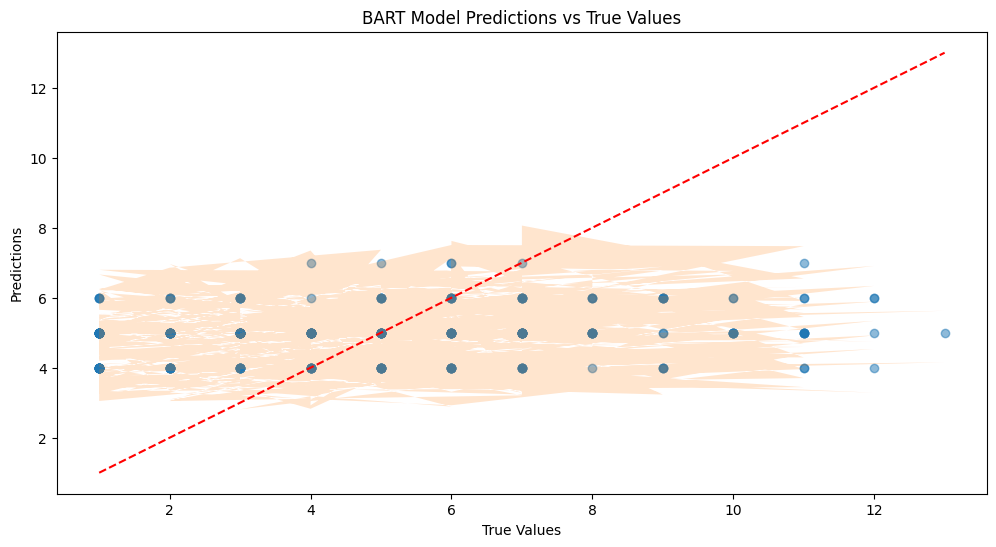

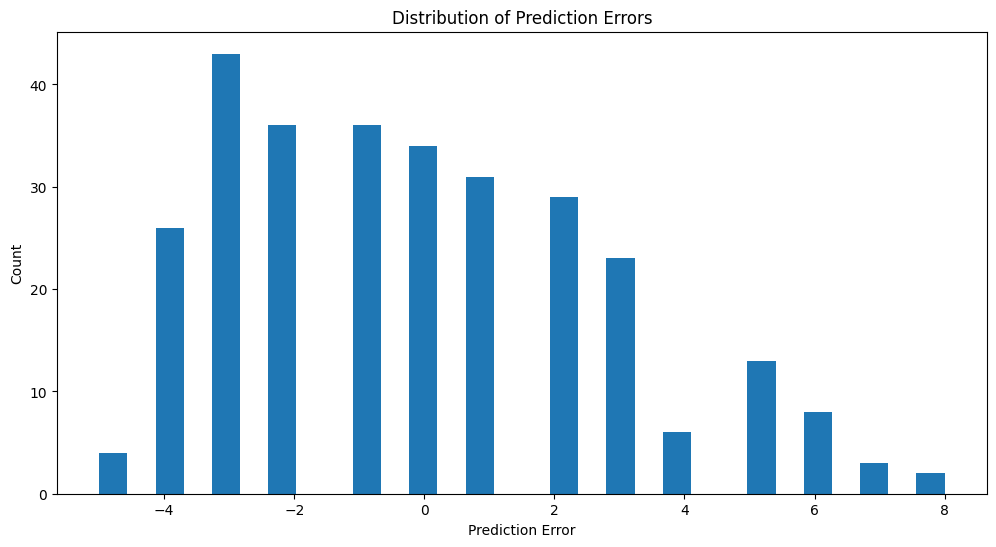

In [64]:
# Calculate predictions and confidence intervals
predicted_means = posterior_predictive.posterior_predictive["μ"].mean(dim=("chain", "draw"))
predicted_stds = posterior_predictive.posterior_predictive["μ"].std(dim=("chain", "draw"))
predicted_ci_lower = posterior_predictive.posterior_predictive["μ"].quantile(0.025, dim=("chain", "draw"))
predicted_ci_upper = posterior_predictive.posterior_predictive["μ"].quantile(0.975, dim=("chain", "draw"))

# Round predictions and clip to valid range
rounded_predictions = np.round(predicted_means)
clipped_predictions = np.clip(rounded_predictions, 
                            y_test.min(), 
                            y_test.max())

# Calculate performance metrics
mse = mean_squared_error(y_test, clipped_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, clipped_predictions)
r2 = r2_score(y_test, clipped_predictions)
accuracy = np.mean(clipped_predictions == y_test)

print("\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test, clipped_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.fill_between(y_test, 
                predicted_ci_lower, 
                predicted_ci_upper, 
                alpha=0.2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('BART Model Predictions vs True Values')
plt.show()

# Plot prediction errors
plt.figure(figsize=(12, 6))
errors = y_test - clipped_predictions
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.show()

In [65]:
# Plot: True vs Predicted Finish Position


In [66]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import pymc as pm
# from pymc_bart import BART

# # Feature engineering
# def engineer_features(X):
#     # Add interaction terms
#     X['Distance_Surface'] = X['Distance'] * X['Surface_Dirt']
#     X['Jockey_Field'] = X['JockeyWinRate'] * X['FieldStrength']
#     X['WinRate_Surface'] = X['WinRate'] * X['SurfaceWinRate']
    
#     # Add polynomial features
#     X['Distance_squared'] = X['Distance'] ** 2
#     X['JockeyWinRate_squared'] = X['JockeyWinRate'] ** 2
    
#     # Add ratio features
#     X['WinRate_to_FieldStrength'] = X['WinRate'] / (X['FieldStrength'] + 1e-6)
#     X['JockeyWinRate_to_FieldStrength'] = X['JockeyWinRate'] / (X['FieldStrength'] + 1e-6)
    
#     return X

# # Apply feature engineering
# X_train_enhanced = engineer_features(X_train.copy())
# X_test_enhanced = engineer_features(X_test.copy())

# with pm.Model() as bart_model:
#     # Register shared data
#     X_shared = pm.MutableData("X", X_train_enhanced)
#     y_shared = pm.MutableData("y", y_train)

#     # BART prior with optimized parameters
#     μ = BART("μ", 
#              X=X_shared, 
#              Y=y_shared,
#              m=100,  # Increased number of trees
#              alpha=0.95,  # Prior probability of splitting
#              beta=1.0)  # Reduced beta for more conservative growth

#     # Noise term with more informative prior
#     sigma = pm.HalfNormal("sigma", sigma=0.2)  # Further reduced sigma

#     # Likelihood
#     y_obs = pm.Normal("y_obs", mu=μ, sigma=sigma, observed=y_shared)

#     # Sample posterior with increased tuning
#     trace = pm.sample(
#         draws=3000,  # Increased draws
#         tune=2000,   # Increased tuning steps
#         chains=4,
#         target_accept=0.95,
#         random_seed=69,
#         return_inferencedata=True,
#         idata_kwargs={"log_likelihood": True}
#     )

# # Diagnostic checks
# print("\nModel Diagnostics:")
# print("R-hat values:", pm.summary(trace)["r_hat"].describe())
# print("\nEffective sample sizes:", pm.summary(trace)["ess_bulk"].describe())

# # Posterior predictive sampling
# with bart_model:
#     pm.set_data({"X": X_test_enhanced})
#     posterior_predictive = pm.sample_posterior_predictive(
#         trace, 
#         var_names=["μ"],
#         return_inferencedata=True,
#         random_seed=69
#     )

# # Calculate predictions and confidence intervals
# predicted_means = posterior_predictive.posterior_predictive["μ"].mean(dim=("chain", "draw"))
# predicted_stds = posterior_predictive.posterior_predictive["μ"].std(dim=("chain", "draw"))
# predicted_ci_lower = posterior_predictive.posterior_predictive["μ"].quantile(0.025, dim=("chain", "draw"))
# predicted_ci_upper = posterior_predictive.posterior_predictive["μ"].quantile(0.975, dim=("chain", "draw"))

# # Round predictions and clip to valid range
# rounded_predictions = np.round(predicted_means)
# clipped_predictions = np.clip(rounded_predictions, 
#                             y_test.min(), 
#                             y_test.max())

# # Calculate performance metrics
# mse = mean_squared_error(y_test, clipped_predictions)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test, clipped_predictions)
# r2 = r2_score(y_test, clipped_predictions)
# accuracy = np.mean(clipped_predictions == y_test)

# print("\nModel Performance:")
# print(f"MSE: {mse:.4f}")
# print(f"RMSE: {rmse:.4f}")
# print(f"MAE: {mae:.4f}")
# print(f"R² Score: {r2:.4f}")
# print(f"Accuracy: {accuracy:.4f}")

# # Visualize predictions
# plt.figure(figsize=(12, 6))
# plt.scatter(y_test, clipped_predictions, alpha=0.5)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.fill_between(y_test, 
#                 predicted_ci_lower, 
#                 predicted_ci_upper, 
#                 alpha=0.2)
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# plt.title('BART Model Predictions vs True Values')
# plt.show()

# # Plot prediction errors
# plt.figure(figsize=(12, 6))
# errors = y_test - clipped_predictions
# plt.hist(errors, bins=30)
# plt.xlabel('Prediction Error')
# plt.ylabel('Count')
# plt.title('Distribution of Prediction Errors')
# plt.show()

# # Feature importance analysis
# feature_importance = trace.posterior["μ"].var(dim=("chain", "draw")).mean(dim="draw")
# feature_importance = feature_importance / feature_importance.sum()
# feature_importance = feature_importance.sort_values(ascending=False)

# plt.figure(figsize=(12, 6))
# feature_importance.plot(kind='bar')
# plt.title('Feature Importance')
# plt.xlabel('Features')
# plt.ylabel('Importance Score')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [67]:
# Predictions data
final_prediction_bart_df = df_final_prediction.copy()

race_number = [4, 5, 6, 7]
X_predict = final_prediction_bart_df[final_prediction_bart_df["RaceNumber"].isin(race_number)]

horse_names = X_predict["HorseName"]
race_ids = X_predict["RaceNumber"]
raceid_ids = X_predict["RaceID"]

features = [
    'Distance', 'Surface_Dirt', 'Surface_Turf', 'AvgPastFinishPosition',
    'WinRate', 'DistanceSuitability', 'JockeyWinRate',
    'FieldStrength', 'SurfaceWinRate'
]
X_predict = X_predict[features]

In [68]:
with bart_model:
    pm.set_data({"X": X_predict})
    posterior_predictive = pm.sample_posterior_predictive(
        trace, var_names=["μ"], return_inferencedata=True
    )
# Extract posterior predictive draws
μ_draws = posterior_predictive.posterior_predictive["μ"]  # (chain, draw, horse)
μ_stacked = μ_draws.stack(sample=("chain", "draw"))       # (sample, horse)
μ_values = μ_stacked.transpose("sample", "μ_dim_0").values  # shape: (num_samples, num_horses)

from collections import defaultdict

# Map race IDs to list of indices (horses)
race_to_indices = defaultdict(list)
for idx, race in enumerate(raceid_ids):
    race_to_indices[race].append(idx)

# Compute first-place probabilities
first_place_probs = np.zeros(len(X_predict))

for race_id, indices in race_to_indices.items():
    race_draws = μ_values[:, indices]  # shape: (samples, horses)
    winners = np.argmin(race_draws, axis=1)

    for rel_idx, abs_idx in enumerate(indices):
        first_place_probs[abs_idx] = np.mean(winners == rel_idx)


Sampling: [μ]


c:\Users\mrlem\AppData\Local\Programs\Python\Python311\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [69]:
results = pd.DataFrame({
    "HorseName": horse_names.values,
    "RaceNumber": race_ids.values,
    "RaceID": raceid_ids.values,
    "FirstPlaceProb": first_place_probs.round(4),
})

results = results.sort_values(by=["RaceID", "FirstPlaceProb"], ascending=[True, False])
print(results.groupby("RaceID").head(5).reset_index(drop=True))


            HorseName  RaceNumber          RaceID  FirstPlaceProb
0   intermittent fast           4  CD _20250515_4          0.9522
1        up the creek           4  CD _20250515_4          0.0235
2      carolina candy           4  CD _20250515_4          0.0138
3         no what ifs           4  CD _20250515_4          0.0088
4   tennesseehoneybee           4  CD _20250515_4          0.0017
5   midnight survivor           5  CD _20250515_5          0.4959
6       paved in gold           5  CD _20250515_5          0.2928
7          strategist           5  CD _20250515_5          0.0754
8              baobab           5  CD _20250515_5          0.0558
9      kevin's strike           5  CD _20250515_5          0.0382
10             liuzza           6  CD _20250515_6          0.5636
11        pens street           6  CD _20250515_6          0.1605
12       klimt's muse           6  CD _20250515_6          0.1289
13      cora's legacy           6  CD _20250515_6          0.0535
14        